Import libraries

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Karena file `wdbc.data` belum memiliki nama kolom, didefinisikan sendiri nama-nama kolom tersebut berdasarkan informasi di `wdbc.names`.

In [49]:
# 1. Mendefinisikan nama kolom (berdasarkan wdbc.names)
features_base = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 
                 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']
# Urutan di UCI -> 10 mean, 10 standard error, 10 worst
columns = ['id', 'diagnosis'] + \
          [f"{f}_mean" for f in features_base] + \
          [f"{f}_se" for f in features_base] + \
          [f"{f}_worst" for f in features_base]

In [50]:
# 2. Membaca dataset
df = pd.read_csv('dataset/wdbc.data', header=None, names=columns)

# 3. Drop kolom ID karena tidak relevan untuk prediksi
df = df.drop('id', axis=1)

In [51]:
display(df.head())

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Split Data dan Preprocessing

In [52]:
# 1. Mengubah target kategorikal M = Malignant (Ganas) -> 1, B = Benign (Jinak) -> 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# 2. Memisahkan Fitur (X) dan Target (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# 3. Membagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Standarisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Jumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")

Jumlah data training: 455
Jumlah data testing: 114


Training dan Test

In [53]:
# Inisialisasi MLP dgn 2 hidden layer
mlp = MLPClassifier(hidden_layer_sizes=(10, 10),
                    activation='relu', 
                    max_iter=100, 
                    solver='adam', 
                    alpha=0.001,
                    random_state=42)

# Proses training
mlp.fit(X_train_scaled, y_train)

# Prediksi
y_pred = mlp.predict(X_test_scaled)

# Evaluasi
print(f"Akurasi MLP: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nLaporan Klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi MLP: 95.61%

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Selanjutnya, akan dilakukan eksperimen dengan menaikkan `max_iter` menjadi 500 atau 1000 untuk memberikan ruang bagi model mencapai konvergensi. Pada bagian ini, dilakukan juga percobaan pada `hidden_layer_sizes` dan `alpha`.

In [54]:
def train_and_evaluate(hidden_layer_sizes, alpha, max_iter):
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='relu',
        solver='adam',
        alpha=alpha,
        max_iter=max_iter,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    return train_acc, test_acc

In [55]:
from itertools import product

def experiment_mlp(hidden_layers_list, alphas, max_iters):
    results = []

    for hls, a, mi in product(hidden_layers_list, alphas, max_iters):
        train_acc, test_acc = train_and_evaluate(hls, a, mi)
        gap = train_acc - test_acc
        
        results.append({
            "hidden_layers": hls,
            "alpha": a,
            "max_iter": mi,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "gap": gap
        })
        
        print(f"HL size={hls}, alpha={a}, max_iter={mi} | "
              f"train={train_acc:.4f}, test={test_acc:.4f}, gap={gap:.4f}")
    
    return results

In [63]:
hidden_layers_sizes = [(20,10), (15,10), (10,10)]
alphas = [0.1, 0.01, 0.001, 0.0001]
max_iters = [500, 1000]

results = experiment_mlp(hidden_layers_sizes, alphas, max_iters)

HL size=(20, 10), alpha=0.1, max_iter=500 | train=0.9297, test=0.9561, gap=-0.0265
HL size=(20, 10), alpha=0.1, max_iter=1000 | train=0.9297, test=0.9561, gap=-0.0265
HL size=(20, 10), alpha=0.01, max_iter=500 | train=0.9297, test=0.9561, gap=-0.0265
HL size=(20, 10), alpha=0.01, max_iter=1000 | train=0.9297, test=0.9561, gap=-0.0265
HL size=(20, 10), alpha=0.001, max_iter=500 | train=0.9297, test=0.9649, gap=-0.0352
HL size=(20, 10), alpha=0.001, max_iter=1000 | train=0.9297, test=0.9649, gap=-0.0352
HL size=(20, 10), alpha=0.0001, max_iter=500 | train=0.9297, test=0.9649, gap=-0.0352
HL size=(20, 10), alpha=0.0001, max_iter=1000 | train=0.9297, test=0.9649, gap=-0.0352
HL size=(15, 10), alpha=0.1, max_iter=500 | train=0.9275, test=0.9386, gap=-0.0111
HL size=(15, 10), alpha=0.1, max_iter=1000 | train=0.9275, test=0.9386, gap=-0.0111
HL size=(15, 10), alpha=0.01, max_iter=500 | train=0.9275, test=0.9386, gap=-0.0111
HL size=(15, 10), alpha=0.01, max_iter=1000 | train=0.9275, test=0.93

Visualisasi

C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_33500\58629886.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='test_acc', y='label', palette='viridis')


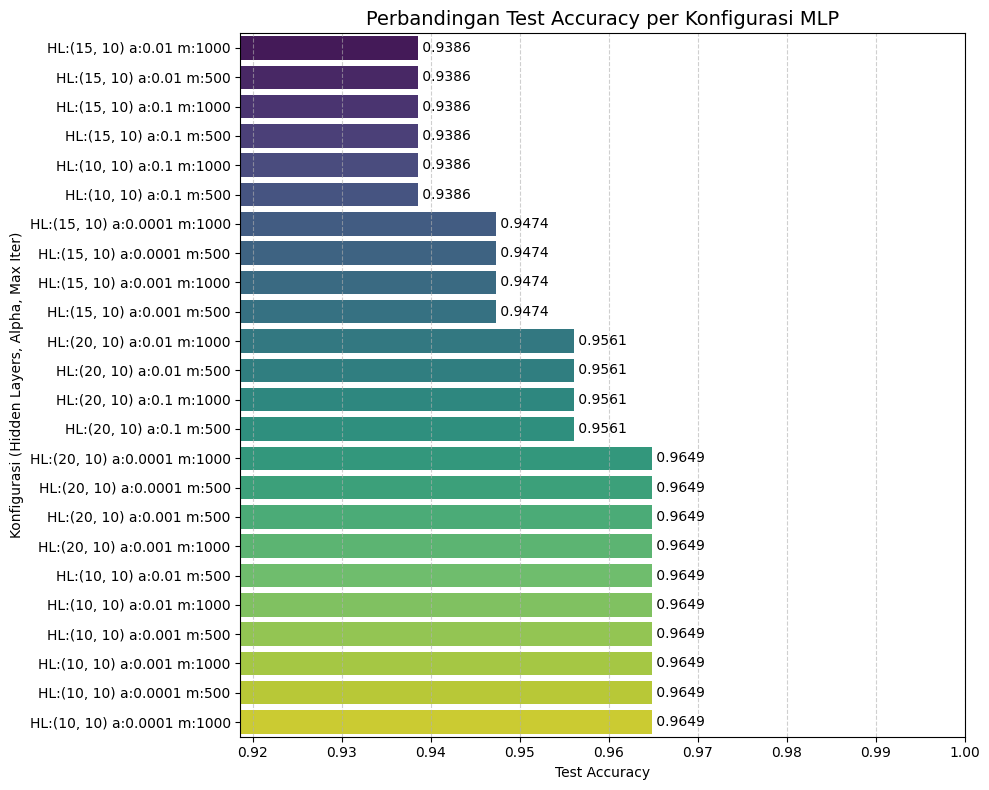

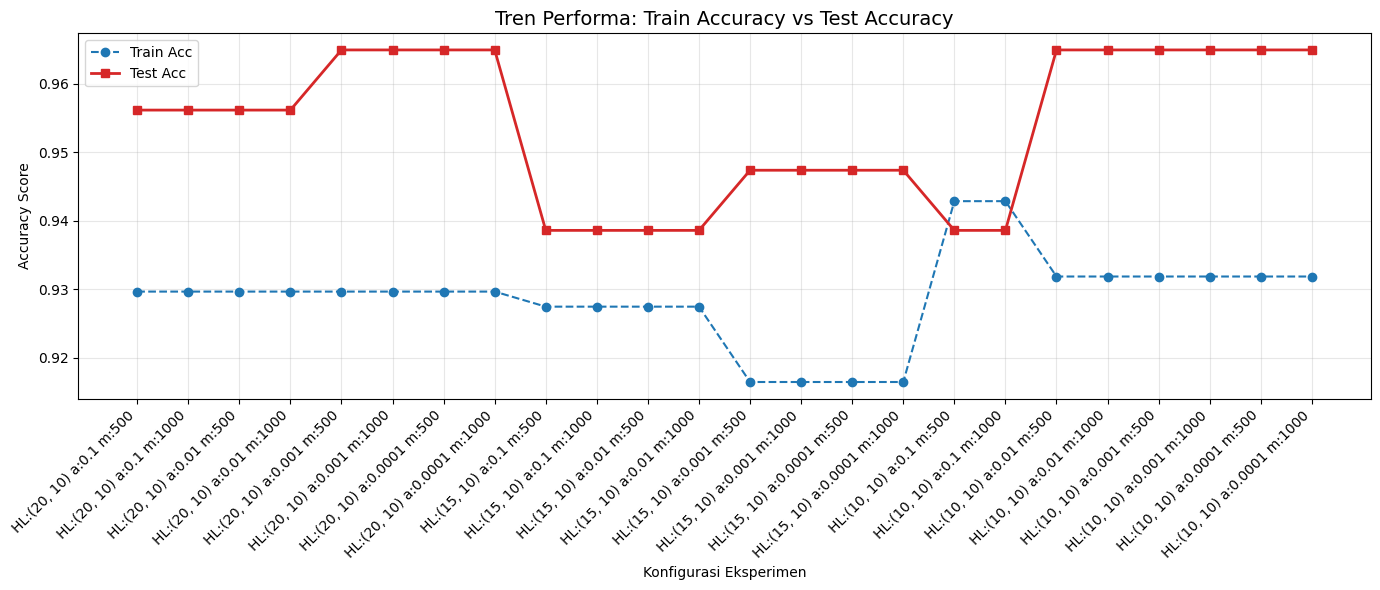

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(results)

# Label
df['label'] = df.apply(lambda x: f"HL:{x['hidden_layers']} a:{x['alpha']} m:{x['max_iter']}", axis=1)

# Bar chart
plt.figure(figsize=(10, 8))
df_sorted = df.sort_values('test_acc', ascending=True)

sns.barplot(data=df_sorted, x='test_acc', y='label', palette='viridis')

# Nilai akurasi di ujung bar
for i, val in enumerate(df_sorted['test_acc']):
    plt.text(val, i, f' {val:.4f}', va='center')

plt.xlim(df['test_acc'].min() - 0.02, 1.0) 
plt.title('Perbandingan Test Accuracy per Konfigurasi MLP', fontsize=14)
plt.xlabel('Test Accuracy')
plt.ylabel('Konfigurasi (Hidden Layers, Alpha, Max Iter)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('bar_chart_test_acc.png')
plt.show()

# Line chart untuk train dan test
plt.figure(figsize=(14, 6))
plt.plot(df['label'], df['train_acc'], marker='o', label='Train Acc', color='#1f77b4', linestyle='--')
plt.plot(df['label'], df['test_acc'], marker='s', label='Test Acc', color='#d62728', linewidth=2)

plt.xticks(rotation=45, ha='right')
plt.title('Tren Performa: Train Accuracy vs Test Accuracy', fontsize=14)
plt.ylabel('Accuracy Score')
plt.xlabel('Konfigurasi Eksperimen')
plt.legend(frameon=True, loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('line_chart_trend.png')
plt.show()

Cross Validation

In [65]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import numpy as np

mlp = MLPClassifier(
    hidden_layer_sizes=(20, 10),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=500,
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validation
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracy tiap fold:", scores)
print(f"Mean accuracy: {scores.mean():.4f}")
print(f"Std deviation: {scores.std():.4f}")

Cross-validation accuracy tiap fold: [0.97368421 0.96491228 0.97368421 0.98245614 0.99115044]
Mean accuracy: 0.9772
Std deviation: 0.0089
